# Finding convex hull using Pointer Network (Ptr-Net)

This code is a simplified version of the code included in the tutorial: [Pointer Networks with Transformers](https://towardsdatascience.com/pointer-networks-with-transformers-1a01d83f7543) &copy; Mason McGough, 2021.

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

### Uncomment in case of using Google colab

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/MyDrive/ptrnets')

### Import the used helper classes and functions

In [3]:
from ptrnets.Data import display_points_with_hull, cyclic_permute, Scatter2DDataset, Disp_results
from ptrnets.ptr_net import ConvexNet, AverageMeter, masked_accuracy, calculate_hull_overlap

### Generate a set of training and validation datasets for training.

In [4]:
min_samples = 5
max_samples = 50
n_rows_train = 100000
n_rows_val = 1000

torch.random.manual_seed(231)
train_dataset = Scatter2DDataset(n_rows_train, min_samples, max_samples)
val_dataset = Scatter2DDataset(n_rows_val, min_samples, max_samples)

print(f'# train: {len(train_dataset):7d}')
print(f'# val:   {len(val_dataset):7d}')

# train:  100000
# val:      1000


### Parameter setting and initialization

In [5]:
TOKENS = {'<eos>': 0 }  # end-of-sequence token 
c_inputs = 2 + len(TOKENS)
c_embed = 16
c_hidden = 16
n_heads = 4
n_layers = 3
dropout = 0.0
use_cuda = True
n_workers = 2

n_epochs = 10
batch_size = 16
lr = 1e-3
log_interval = 500

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size,
  num_workers=n_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
  num_workers=n_workers)

model = ConvexNet(c_inputs=c_inputs, c_embed=c_embed, n_heads=n_heads,
  n_layers=n_layers, dropout=dropout, c_hidden=c_hidden).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss(ignore_index=TOKENS['<eos>'])

train_loss = AverageMeter()
train_accuracy = AverageMeter()
val_loss = AverageMeter()
val_accuracy = AverageMeter()

### Model training and validation

In [6]:
# Training loop
for epoch in range(n_epochs):
  model.train()
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(train_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    optimizer.zero_grad()
    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths, batch_labels=batch_labels)
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels.reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    loss.backward()
    optimizer.step()

    train_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    train_accuracy.update(acc, mask.int().sum().item())

    if bat % log_interval == 0:
      print(f'Epoch {epoch}: '
            f'Train [{bat * len(batch_data):9d}/{len(train_dataset):9d} '
            f'Loss: {train_loss.avg:.6f}\tAccuracy: {train_accuracy.avg:3.4%}')

  # Validation loop    
  model.eval()
  hull_overlaps = []
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(val_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths,
      batch_labels=batch_labels)
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels.reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    val_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    val_accuracy.update(acc, mask.int().sum().item())

    for data, length, ptr in zip(batch_data.cpu(), batch_lengths.cpu(),
        pointer_argmaxs.cpu()):
      hull_overlaps.append(calculate_hull_overlap(data, length, ptr))

  # Display validation results
  print(f'Epoch {epoch}: Val\tLoss: {val_loss.avg:.6f} '
        f'\tAccuracy: {val_accuracy.avg:3.4%} '
        f'\tOverlap: {np.mean(hull_overlaps):3.4%}')
  
  # Reset metrics
  train_loss.reset()
  train_accuracy.reset()
  val_loss.reset()
  val_accuracy.reset()

Epoch 0: Train [        0/   100000 Loss: 3.209383	Accuracy: 0.0000%
Epoch 0: Train [     8000/   100000 Loss: 1.660003	Accuracy: 55.0142%
Epoch 0: Train [    16000/   100000 Loss: 1.183197	Accuracy: 67.5382%
Epoch 0: Train [    24000/   100000 Loss: 0.949370	Accuracy: 73.5899%
Epoch 0: Train [    32000/   100000 Loss: 0.802904	Accuracy: 77.3705%
Epoch 0: Train [    40000/   100000 Loss: 0.704512	Accuracy: 79.9138%
Epoch 0: Train [    48000/   100000 Loss: 0.633706	Accuracy: 81.7346%
Epoch 0: Train [    56000/   100000 Loss: 0.578830	Accuracy: 83.1493%
Epoch 0: Train [    64000/   100000 Loss: 0.536112	Accuracy: 84.2508%
Epoch 0: Train [    72000/   100000 Loss: 0.501778	Accuracy: 85.1343%
Epoch 0: Train [    80000/   100000 Loss: 0.473257	Accuracy: 85.8830%
Epoch 0: Train [    88000/   100000 Loss: 0.448689	Accuracy: 86.5243%
Epoch 0: Train [    96000/   100000 Loss: 0.428071	Accuracy: 87.0499%
Epoch 0: Val	Loss: 0.170081 	Accuracy: 93.8810% 	Overlap: 44.7449%
Epoch 1: Train [        

### Save the trained model

In [7]:
# PATH='/ptrnets'
# torch.save(model.state_dict(), PATH)

### Display the results in terms of training and validation losses and accuracies

Best Scores:
train_loss: 0.0915 (ep: 9)
train_accuracy 96.53% (ep: 9)
val_loss: 0.0884 (ep: 5)
val_accuracy: 96.83% (ep: 5)


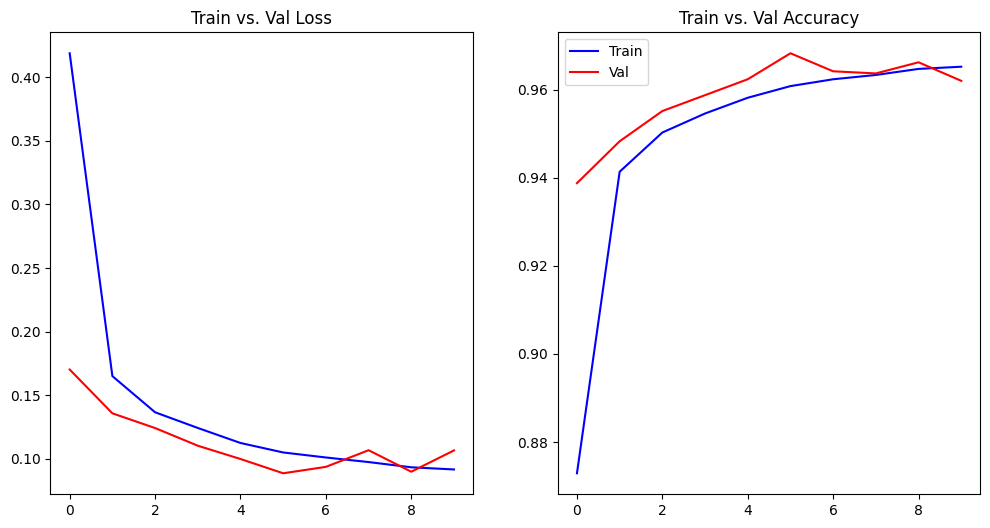

In [8]:
Disp_results(train_loss, train_accuracy, val_loss, val_accuracy, n_epochs)

### Evaluate the trained model on testing set

Generate a testing dataset to evaluate the performance of our trained model.

In [9]:
n_rows_test = 1000

def test(model, n_rows_test, n_per_row):
  test_dataset = Scatter2DDataset(n_rows_test, n_per_row, n_per_row)
  test_loader = DataLoader(test_dataset, batch_size=batch_size,
    num_workers=n_workers)

  test_accuracy = AverageMeter()
  hull_overlaps = []
  model.eval()
  for _, (batch_data, batch_labels, batch_lengths) in enumerate(test_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    _, pointer_argmaxs = model(batch_data, batch_lengths)

    val_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    test_accuracy.update(acc, mask.int().sum().item())

    for data, length, ptr in zip(batch_data.cpu(), batch_lengths.cpu(),
        pointer_argmaxs.cpu()):
      hull_overlaps.append(calculate_hull_overlap(data, length, ptr))

  print(f'# Test Samples: {n_per_row:3d}\t '
        f'\tAccuracy: {test_accuracy.avg:3.1%} '
        f'\tOverlap: {np.mean(hull_overlaps):3.1%}')

for i in range(5,50,5):
  test(model, n_rows_test, i)

# Test Samples:   5	 	Accuracy: 27.8% 	Overlap: 6.2%
# Test Samples:  10	 	Accuracy: 31.2% 	Overlap: 49.5%
# Test Samples:  15	 	Accuracy: 61.7% 	Overlap: 86.9%
# Test Samples:  20	 	Accuracy: 84.1% 	Overlap: 92.3%
# Test Samples:  25	 	Accuracy: 85.9% 	Overlap: 90.7%
# Test Samples:  30	 	Accuracy: 85.1% 	Overlap: 89.1%
# Test Samples:  35	 	Accuracy: 83.1% 	Overlap: 84.0%
# Test Samples:  40	 	Accuracy: 81.5% 	Overlap: 77.2%
# Test Samples:  45	 	Accuracy: 78.1% 	Overlap: 71.4%


### Display an example prediction

Generate and visualize an example convex hull with our model.

In [12]:
idx = 0
n_per_row = 50

test_dataset = Scatter2DDataset(n_rows_test, n_per_row, n_per_row)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
  num_workers=n_workers)
batch_data, batch_labels, batch_lengths = next(iter(test_loader))
print(batch_data.shape,batch_lengths.shape)
log_pointer_scores, pointer_argmaxs = model(batch_data.to(device),
  batch_lengths.to(device))
pred_hull_idxs = pointer_argmaxs[idx].cpu()
pred_hull_idxs = pred_hull_idxs[pred_hull_idxs > 1] - 2
points = batch_data[idx, 2:batch_lengths[idx], :2]
points1 = batch_data[idx, 1:batch_lengths[idx], :2]
print(points.shape,)
true_hull_idxs = ConvexHull(points).vertices.tolist()
true_hull_idxs = cyclic_permute(true_hull_idxs, np.argmin(true_hull_idxs))

overlap = calculate_hull_overlap(batch_data[idx].cpu(), batch_lengths[idx].cpu(),
  pointer_argmaxs[idx].cpu())

print(f'Predicted: {pred_hull_idxs.tolist()}')
print(f'True:      {true_hull_idxs}')
print(f'Hull overlap: {overlap:3.2%}')

torch.Size([16, 51, 3]) torch.Size([16])
torch.Size([49, 2])
Predicted: [0, 3, 5, 31, 45, 47, 48, 40, 10]
True:      [0, 3, 5, 31, 45, 47, 48, 40, 10]
Hull overlap: 100.00%


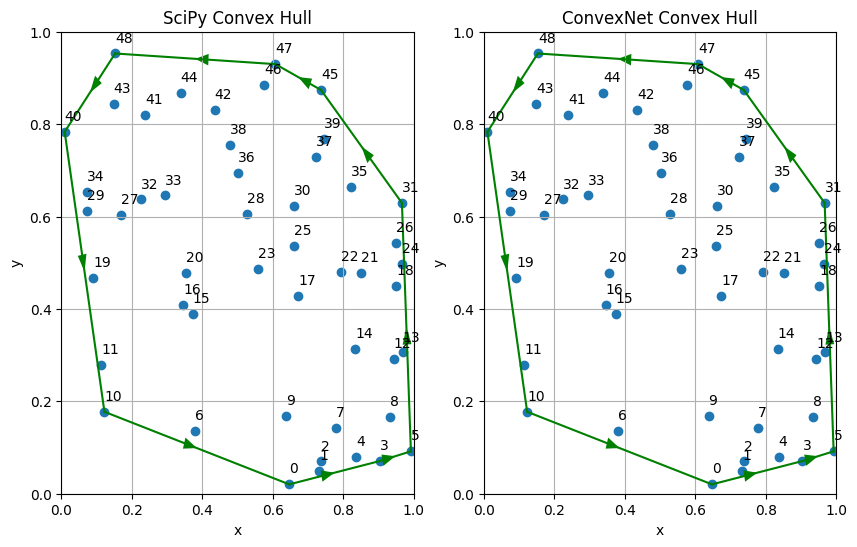

In [13]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.subplot(1, 2, 1)
true_hull_idxs = ConvexHull(points).vertices.tolist()
display_points_with_hull(points, true_hull_idxs)
_ = plt.title('SciPy Convex Hull')

plt.subplot(1, 2, 2)
display_points_with_hull(points, pred_hull_idxs)
_ = plt.title('ConvexNet Convex Hull')
plt.savefig('ConvexNet.png', dpi=600)